# Pairwise PID Synergy Matrices on Benchmark Datasets

This notebook demonstrates the computation and analysis of **Partial Information Decomposition (PID)** synergy matrices on benchmark classification datasets.

**What it does:**
- Loads pre-computed PID results (synergy, redundancy, unique information) for all feature pairs
- Analyzes the PID decomposition to understand how feature pairs jointly encode class information
- Compares PID synergy against Co-Information (CoI) baseline
- Visualizes synergy matrices as heatmaps and PID decomposition bar charts

**Method:** PID_BROJA for small datasets (≤100 pairs), PID_MMI for larger ones, with Co-Information baseline.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# All packages used are pre-installed on Colab; install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'matplotlib==3.10.0', 'seaborn==0.13.2')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from itertools import combinations

## Data Loading

Load pre-computed PID synergy results from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-b88b52-synergy-guided-oblique-splits-using-part/main/experiment_iter2_pairwise_pid_sy/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} datasets")
for ds in data['datasets']:
    print(f"  {ds['dataset']}: {len(ds['examples'])} feature pairs")

Loaded 2 datasets
  banknote: 6 feature pairs
  iris: 6 feature pairs


## Configuration

Tunable parameters for the analysis. These match the original experiment settings.

In [5]:
# ── Configuration ────────────────────────────────────────────────────
# Original experiment parameters:
# N_BINS = 5               # Discretization bins
# BROJA_PAIR_LIMIT = 100   # Max pairs for BROJA (else fallback to MMI)
# SYNERGY_THRESHOLD_PCTL = 75  # Percentile for synergy graph threshold

# Demo parameters (analysis of pre-computed results)
SYNERGY_THRESHOLD_PCTL = 75  # Percentile for synergy graph threshold
TOP_K_PAIRS = 5              # Number of top synergy pairs to display

## Parse PID Results

Extract synergy, redundancy, unique information, and Co-Information baseline from each feature pair. Build a DataFrame for analysis.

In [6]:
rows = []
for ds in data['datasets']:
    ds_name = ds['dataset']
    for ex in ds['examples']:
        inp = json.loads(ex['input'])
        out = json.loads(ex['output'])
        rows.append({
            'dataset': ds_name,
            'feature_i': inp['feature_i'],
            'feature_j': inp['feature_j'],
            'n_samples': inp['n_samples'],
            'n_classes': inp['n_classes'],
            'pid_method': ex['metadata_pid_method'],
            'synergy': out['synergy'],
            'unique_0': out['unique_0'],
            'unique_1': out['unique_1'],
            'redundancy': out['redundancy'],
            'coi_baseline': out.get('coi_baseline', 0.0),
        })

df = pd.DataFrame(rows)
df['pair'] = df['feature_i'] + ' x ' + df['feature_j']
df['total_mi'] = df['synergy'] + df['unique_0'] + df['unique_1'] + df['redundancy']
print(f"Parsed {len(df)} feature pairs across {df['dataset'].nunique()} datasets")
df.head()

Parsed 12 feature pairs across 2 datasets


,dataset,feature_i,feature_j,n_samples,n_classes,pid_method,synergy,unique_0,unique_1,redundancy,coi_baseline,pair,total_mi
0,banknote,V1,V2,1372,2,BROJA,0.192849,0.342073,0.000000,0.149710,-0.103770,V1 x V2,0.684632
1,banknote,V1,V3,1372,2,BROJA,0.108733,0.443605,0.000000,0.048178,-0.033393,V1 x V3,0.600516
2,banknote,V1,V4,1372,2,BROJA,0.095736,0.486463,0.000000,0.005319,-0.003687,V1 x V4,0.587518
3,banknote,V2,V3,1372,2,BROJA,0.255606,0.101629,0.000101,0.048079,-0.033393,V2 x V3,0.405415
4,banknote,V2,V4,1372,2,BROJA,0.261054,0.144393,0.000004,0.005315,-0.003687,V2 x V4,0.410766


## Build Synergy Matrices

Reconstruct the pairwise synergy matrix for each dataset from the PID results.

In [7]:
synergy_matrices = {}
for ds_name, ds_df in df.groupby('dataset'):
    features = sorted(set(ds_df['feature_i'].tolist() + ds_df['feature_j'].tolist()))
    n_feat = len(features)
    feat_idx = {f: i for i, f in enumerate(features)}

    syn_mat = np.zeros((n_feat, n_feat))
    for _, row in ds_df.iterrows():
        i, j = feat_idx[row['feature_i']], feat_idx[row['feature_j']]
        syn_mat[i, j] = row['synergy']
        syn_mat[j, i] = row['synergy']

    synergy_matrices[ds_name] = {
        'matrix': syn_mat,
        'features': features,
        'n_samples': int(ds_df['n_samples'].iloc[0]),
        'n_classes': int(ds_df['n_classes'].iloc[0]),
        'pid_method': ds_df['pid_method'].iloc[0],
    }
    print(f"{ds_name}: {n_feat}x{n_feat} synergy matrix, "
          f"{ds_df['n_samples'].iloc[0]} samples, "
          f"{ds_df['n_classes'].iloc[0]} classes, "
          f"method={ds_df['pid_method'].iloc[0]}")

banknote: 4x4 synergy matrix, 1372 samples, 2 classes, method=BROJA
iris: 4x4 synergy matrix, 150 samples, 3 classes, method=BROJA


## Synergy Graph Construction

Build a synergy graph by thresholding the synergy matrix at the configured percentile. Edges connect feature pairs with synergy above the threshold.

In [8]:
graph_stats = {}
for ds_name, info in synergy_matrices.items():
    syn_mat = info['matrix']
    features = info['features']
    n_feat = len(features)
    pairs = list(combinations(range(n_feat), 2))

    syn_vals = [syn_mat[i, j] for (i, j) in pairs]
    if not syn_vals or max(syn_vals) == 0:
        graph_stats[ds_name] = {'threshold': 0, 'n_edges': 0, 'edges': []}
        continue

    threshold = float(np.percentile(syn_vals, SYNERGY_THRESHOLD_PCTL))

    edges = []
    for (i, j) in pairs:
        if syn_mat[i, j] >= threshold:
            edges.append({
                'feature_i': features[i],
                'feature_j': features[j],
                'synergy': syn_mat[i, j],
            })

    graph_stats[ds_name] = {
        'threshold': threshold,
        'n_edges': len(edges),
        'edges': sorted(edges, key=lambda e: e['synergy'], reverse=True),
    }
    print(f"{ds_name}: threshold={threshold:.4f}, "
          f"{len(edges)} edges above threshold")

banknote: threshold=0.2399, 2 edges above threshold
iris: threshold=0.2030, 2 edges above threshold


## Results Summary

Print key results: per-dataset statistics and top synergy pairs.

In [9]:
print("=" * 60)
print("PID SYNERGY ANALYSIS RESULTS")
print("=" * 60)

for ds_name, ds_df in df.groupby('dataset'):
    info = synergy_matrices[ds_name]
    gs = graph_stats[ds_name]
    print(f"\n--- {ds_name} ---")
    print(f"  Samples: {info['n_samples']}, "
          f"Classes: {info['n_classes']}, "
          f"Features: {len(info['features'])}, "
          f"Method: {info['pid_method']}")
    print(f"  Synergy: mean={ds_df['synergy'].mean():.4f}, "
          f"std={ds_df['synergy'].std():.4f}, "
          f"max={ds_df['synergy'].max():.4f}")
    print(f"  Redundancy: mean={ds_df['redundancy'].mean():.4f}, "
          f"max={ds_df['redundancy'].max():.4f}")
    print(f"  Graph: {gs['n_edges']} edges "
          f"(threshold={gs['threshold']:.4f})")

    # Top synergy pairs
    top = ds_df.nlargest(min(TOP_K_PAIRS, len(ds_df)), 'synergy')
    print(f"  Top {len(top)} synergy pairs:")
    for _, r in top.iterrows():
        print(f"    {r['pair']:40s} syn={r['synergy']:.4f} "
              f"red={r['redundancy']:.4f} "
              f"coi={r['coi_baseline']:.4f}")

PID SYNERGY ANALYSIS RESULTS

--- banknote ---
  Samples: 1372, Classes: 2, Features: 4, Method: BROJA
  Synergy: mean=0.1599, std=0.0898, max=0.2611
  Redundancy: mean=0.0436, max=0.1497
  Graph: 2 edges (threshold=0.2399)
  Top 5 synergy pairs:
    V2 x V4                                  syn=0.2611 red=0.0053 coi=-0.0037
    V2 x V3                                  syn=0.2556 red=0.0481 coi=-0.0334
    V1 x V2                                  syn=0.1928 red=0.1497 coi=-0.1038
    V1 x V3                                  syn=0.1087 red=0.0482 coi=-0.0334
    V1 x V4                                  syn=0.0957 red=0.0053 coi=-0.0037

--- iris ---
  Samples: 150, Classes: 3, Features: 4, Method: BROJA
  Synergy: mean=0.1494, std=0.0805, max=0.2548
  Redundancy: mean=0.5778, max=1.0739
  Graph: 2 edges (threshold=0.2030)
  Top 5 synergy pairs:
    sepal length (cm) x sepal width (cm)     syn=0.2548 red=0.2941 coi=-0.2751
    sepal width (cm) x petal length (cm)     syn=0.2049 red=0.3931

## Visualization

### 1. Synergy Heatmaps
Pairwise synergy matrices for each dataset, showing which feature pairs have highest synergistic information about the target.

### 2. PID Decomposition
Stacked bar charts showing how mutual information decomposes into synergy, redundancy, and unique components for each pair.

### 3. Synergy vs Co-Information
Scatter plot comparing PID synergy against the Co-Information baseline (negative CoI indicates synergy).

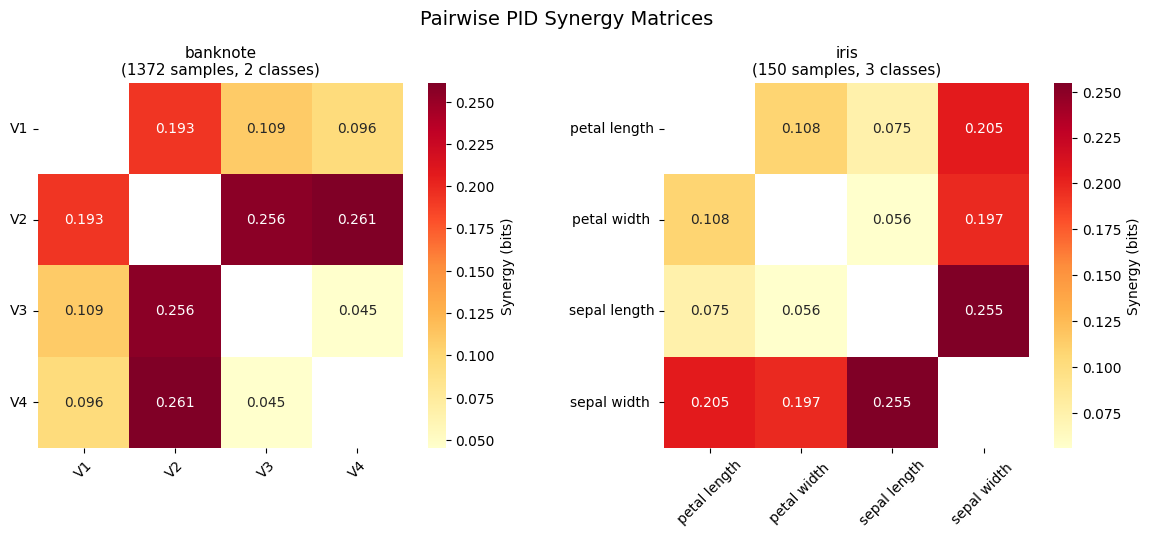

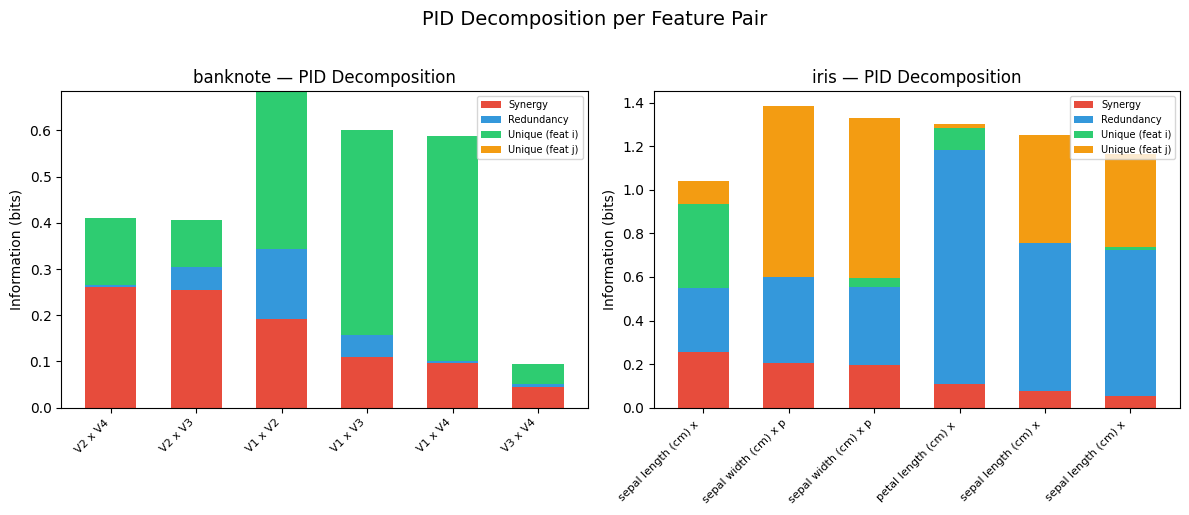

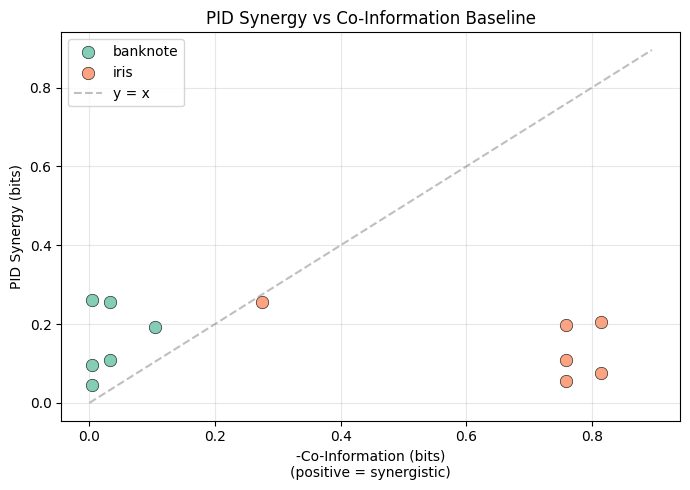

Visualization complete.


In [10]:
n_datasets = len(synergy_matrices)

# ── Figure 1: Synergy Heatmaps ──────────────────────────────────────
fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 5))
if n_datasets == 1:
    axes = [axes]

for ax, (ds_name, info) in zip(axes, sorted(synergy_matrices.items())):
    syn_mat = info['matrix']
    features = info['features']
    # Shorten feature names for display
    short_names = [f[:12] for f in features]

    mask = np.eye(len(features), dtype=bool)
    sns.heatmap(
        syn_mat,
        mask=mask,
        annot=True,
        fmt='.3f',
        cmap='YlOrRd',
        xticklabels=short_names,
        yticklabels=short_names,
        ax=ax,
        square=True,
        cbar_kws={'label': 'Synergy (bits)'},
    )
    ax.set_title(f'{ds_name}\n({info["n_samples"]} samples, '
                 f'{info["n_classes"]} classes)', fontsize=11)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

plt.suptitle('Pairwise PID Synergy Matrices', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ── Figure 2: PID Decomposition ─────────────────────────────────────
fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 5))
if n_datasets == 1:
    axes = [axes]

for ax, (ds_name, ds_df) in zip(axes, sorted(df.groupby('dataset'))):
    ds_df = ds_df.sort_values('synergy', ascending=False)
    pairs_short = [p[:20] for p in ds_df['pair']]

    x = np.arange(len(ds_df))
    width = 0.6

    bottom = np.zeros(len(ds_df))
    for component, color, label in [
        ('synergy', '#e74c3c', 'Synergy'),
        ('redundancy', '#3498db', 'Redundancy'),
        ('unique_0', '#2ecc71', 'Unique (feat i)'),
        ('unique_1', '#f39c12', 'Unique (feat j)'),
    ]:
        vals = ds_df[component].values
        ax.bar(x, vals, width, bottom=bottom, color=color, label=label)
        bottom += vals

    ax.set_xticks(x)
    ax.set_xticklabels(pairs_short, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Information (bits)')
    ax.set_title(f'{ds_name} — PID Decomposition')
    ax.legend(fontsize=7, loc='upper right')

plt.suptitle('PID Decomposition per Feature Pair', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ── Figure 3: Synergy vs Co-Information ──────────────────────────────
fig, ax = plt.subplots(figsize=(7, 5))
colors = sns.color_palette('Set2', n_datasets)
for idx, (ds_name, ds_df) in enumerate(sorted(df.groupby('dataset'))):
    ax.scatter(
        -ds_df['coi_baseline'],  # Negate: positive = synergistic
        ds_df['synergy'],
        label=ds_name,
        color=colors[idx],
        s=80,
        edgecolors='black',
        linewidth=0.5,
        alpha=0.8,
    )

# Diagonal reference
lims = [0, max(df['synergy'].max(), (-df['coi_baseline']).max()) * 1.1]
ax.plot(lims, lims, '--', color='gray', alpha=0.5, label='y = x')
ax.set_xlabel('-Co-Information (bits)\n(positive = synergistic)')
ax.set_ylabel('PID Synergy (bits)')
ax.set_title('PID Synergy vs Co-Information Baseline')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Visualization complete.")